In [16]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy.optimize import minimize
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize



import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

# Dynamic fee algorithm

"token1": {
          "decimals": "18",
          "symbol": "WETH"
        },
"token0": {
  "decimals": "6",
  "symbol": "USDC"
},

amount0: how many of USDC the pool received during this swap 

amount1: how many of WETH the pool received during this swap

if amount1 is positive, it means the pool received a sell order of WETH.

if amount1 is negative, it means the pool received a buy order of WETH.

In [17]:
df = pd.concat([pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl'), pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl'), pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')],axis=0)
df.drop_duplicates(inplace=True)
df.set_index('time_dex', inplace=True)

In [32]:
def zscore(series):
    return (series - series.mean()) / series.std()

# divide by notional amount -- percentage profits
# pool_fee is kept
def calculate_arbitrageur_profit_fixed(row):
    return (row['LVR'] - row['tcost_usd'])/row['amountUSD']

def calculate_arbitrageur_profit_dynamic_quadratic(row):
    return row['LVR'] - row['f_quadratic']*row['amountUSD'] - row['tcost_usd']

# # in percentage
# # TODO ????
# def calculate_price_impact(row):
#     k = (row['amount0']/row['amount1']).abs()
    
#     return row['price_dex']*row['amount1']


# def calculate_impermanent_loss(row):
#     return row['impermanent_loss']*row['amountUSD']

df['pool_fee'] = df['amountUSD']*0.05/100
df['delta_p'] = zscore(df['price_cex']-df['price_dex'])

# in USD
df['arb_profit_fixed'] =  df.apply(lambda row: calculate_arbitrageur_profit_fixed(row), axis=1)
df['arb_profit_pool'] = df['arb_profit_fixed'] - df['pool_fee']
# in %
# df['price_impact'] = (df['price_dex'].pct_change(1).shift(-1)*100).fillna(method='bfill').fillna(method='ffill')
# df['impermanent_loss'] = (2 * np.sqrt(df['price_dex'].shift(1) / df['price_dex']) / (1 + df['price_dex'].shift(1) / df['price_dex']) - 1).fillna(0)
# # in USD
# df['impermanent_loss'] = df.apply(lambda row: calculate_impermanent_loss(row),axis=1)

# assume arb makes positive profits, and trade with bigger price difference
condition_is_noise = (df['delta_p'] > -2) & (df['delta_p'] < 2) & (df['arb_profit_fixed'] < 0)
df['is_arb'] = ~condition_is_noise
df



,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,LVR_cumm,pool_fee,delta_p,arb_profit_fixed,arb_profit_pool,notional_profit,f_dynamic,damm_fee,arb_profit_dynamic,is_arb
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:23,18096.796543,-7.930474,18076.269412,0xe743a49f04f2f77eb2d3b753ae3ad599de8cea84,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x4fd39c9e151e50580779bd04b1f7ecc310079fd3,1.704067e+09,427523,1.358341e+10,1.358341e-08,...,2.468898e+00,9.038135,0.154395,-0.000869,-9.039004,-15.714460,0.000100,1.807627,-17.522087,False
2024-01-01 00:00:23,700.000000,-0.306764,699.212694,0xa1179a0b94e53ee82b77c6d24c2cf67a656c2503,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704067e+09,312000,1.438341e+10,1.438341e-08,...,2.564399e+00,0.349606,0.154395,-0.014776,-0.364382,-10.331225,0.000100,0.069921,-10.401146,False
2024-01-01 00:00:47,25000.000000,-10.955150,24971.093893,0x9b4306e7b6ede125b5e8cac309ffb58af5eed6f0,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,223193,1.259051e+10,1.259051e-08,...,1.990892e+01,12.485547,0.724286,-0.000951,-12.486498,-23.754694,0.000262,6.538313,-30.293007,False
2024-01-01 00:00:59,767.722283,-0.336412,766.824534,0xc10527cdbc055b7f9a8a4ad765b287190c861c51,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704067e+09,247124,1.230578e+10,1.230578e-08,...,2.044154e+01,0.383412,0.724286,-0.009741,-0.393153,-7.469587,0.000262,0.200782,-7.670368,False
2024-01-01 00:01:23,170.905965,-0.074890,170.706032,0xf468072ca8f81e11655c252a37317e814b24872b,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0xa9cffe466ba8a72707d1104de239c9ab477e2493,1.704067e+09,2673946,1.443436e+10,1.443436e-08,...,2.048147e+01,0.085353,0.253825,-0.515993,-0.601346,-88.083121,0.000100,0.017071,-88.100191,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 23:59:23,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,8.684891e+06,1.140037,-0.008847,-0.009062,-1.149100,-20.663160,0.000100,0.228007,-20.891167,False
2024-01-31 23:59:47,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,8.684891e+06,7.495437,0.013556,-0.000858,-7.496295,-12.867196,0.000100,1.499087,-14.366283,False
2024-01-31 23:59:59,164318.889753,-71.961440,164190.258312,0x1fd0c666094d8c5dae247aa6c3c4c33fd21bdc91,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.706746e+09,1673514,2.378692e+10,2.378692e-08,...,8.685006e+06,82.095129,-0.702250,0.000148,-82.094981,24.293104,0.000243,39.826783,-15.533679,True


f_sell is systematically higher than f_buy because Price on Dex is higher than Price on CEX 

# calibrate $\omega$ on buy and sell side: regress delta_p on Arb Profit

In [20]:
# profit % kept by arbitrageur after dynamic fee
intercept_constant = 0.0002
f_min=0.0001
f_max=0.003

# in %
def calc_f_dynamic(row, f_min, f_max, intercept_constant):
    return min(f_max, f_min + max(0, row['f_dynamic']-intercept_constant))
def calc_uv3_notional_profit(row):
    return row['notional_profit']-0.0005*row['amountUSD']
def calc_damm_notional_profit(row):
    return row['notional_profit'] - row['f_dynamic']*row['amountUSD']
# in USD
def calc_damm_fee(row):
    return row['f_dynamic']*row['amountUSD']

Arbitrageur txs percentage: 3.0850%
OLS Model Parameters:
  Slope: 0.0009
  Intercept: -0.0003


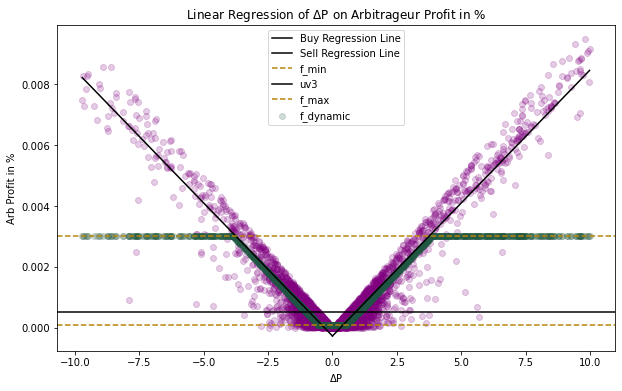

In [21]:

df_winsorize = df[(df['delta_p'] >= -10) & (df['delta_p'] <= 10) & (df['arb_profit_fixed'] >= 0) & (df['arb_profit_fixed'] <= 100)][['delta_p','arb_profit_fixed','amountUSD']].reset_index(drop=True)
df_winsorize['notional_profit'] = df_winsorize.apply(lambda row: row['arb_profit_fixed']*row['amountUSD'], axis=1)
delta_mean = df_winsorize['delta_p'].mean()
# keep the index of sell orders, and convert delta_p to positive
index_sell = df_winsorize[df_winsorize['delta_p']<0].index
df_winsorize['delta_p'] = df_winsorize['delta_p'].abs()

X, y = df_winsorize['delta_p'].values.reshape(-1,1), df_winsorize['arb_profit_fixed']

print(f"Arbitrageur txs percentage: {len(df_winsorize)/len(df)*100:.4f}%")
model_ols = LinearRegression()
model_ols.fit(X, y)
y_pred = model_ols.predict(X)

print("OLS Model Parameters:")
print(f"  Slope: {model_ols.coef_[0]:.4f}")
print(f"  Intercept: {model_ols.intercept_:.4f}")


df_winsorize.loc[index_sell, 'delta_p'] = -df_winsorize.loc[index_sell, 'delta_p']
df_winsorize['f_dynamic'] = np.array(y_pred)
df_winsorize['f_dynamic'] = df_winsorize.apply(lambda row: calc_f_dynamic(row, f_min, f_max, intercept_constant), axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='purple', alpha=0.2)
plt.xlabel("$\Delta$P")
plt.ylabel("Arb Profit in %")
plt.title("Linear Regression of $\Delta$P on Arbitrageur Profit in %")

line_x_buy = np.array([0, X.max()])
line_y_buy = model_ols.coef_[0] * line_x_buy + model_ols.intercept_
plt.plot(line_x_buy, line_y_buy, color='black', label='Buy Regression Line')

line_x_sell = np.array([X.min(), 0])
line_y_sell = model_ols.coef_[0] * line_x_sell * (-1) + model_ols.intercept_
plt.plot(line_x_sell, line_y_sell, color='black', label='Sell Regression Line')

plt.axhline(y=f_min, label='f_min', color='#B8860B', linestyle='--')
plt.axhline(y=0.0005, label='uv3', color='black')
plt.axhline(y=f_max, label='f_max',color='#B8860B', linestyle='--')

# plt.plot(line_x_sell, line_y_sell-intercept_constant, color='#228B22', label='f_sell')
# plt.plot(line_x_buy, line_y_buy-intercept_constant, color='#228B22', label='f_buy')
plt.scatter(X, df_winsorize['f_dynamic'], color='#205843', alpha=0.2, label="f_dynamic")

plt.legend()
plt.show()



94.7888% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: 0.0006
84.3144% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: 0.0004


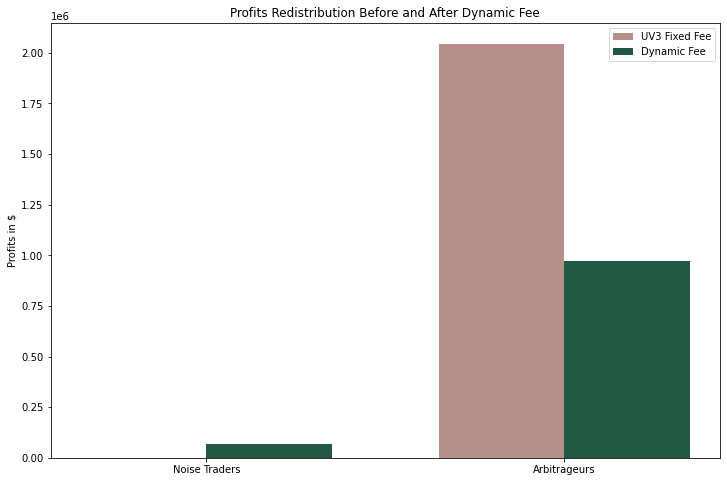

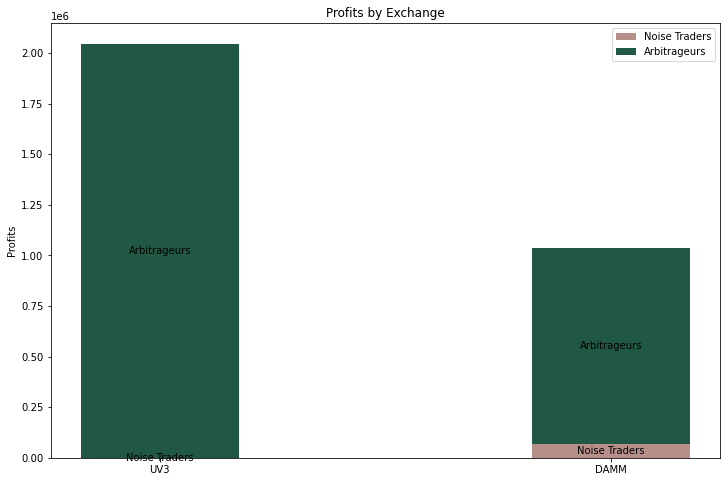

(0       -1.413220
 1        6.292815
 2      -44.257732
 3      -40.975140
 4        0.469865
           ...    
 5771    -8.276615
 5772    46.538863
 5773    -7.061136
 5774   -26.704767
 5775   -57.802025
 Length: 4870, dtype: float64,
 58        293.201989
 87        598.771435
 97       1156.571848
 123      1471.311247
 140       958.354872
             ...     
 5732      759.118119
 5748     9591.820246
 5749     5180.666534
 5750     5890.274811
 5751    10286.147717
 Length: 906, dtype: float64)

In [24]:
def analyze_profit_redistribution(df_winsorize):
    condition_ratio_2 = (df_winsorize['delta_p'] >= -2) & (df_winsorize['delta_p'] <= 2)
    tx_ratio_2 = df_winsorize[condition_ratio_2]
    tx_outside_2 = df_winsorize[~condition_ratio_2]
    tx_ratio_5 = df_winsorize[(df_winsorize['delta_p'] >= -5) & (df_winsorize['delta_p'] <= 5)]
    avg_profit_ratio_2 = tx_ratio_2['arb_profit_fixed'].mean()
    avg_profit_ratio_5 = tx_ratio_5['arb_profit_fixed'].mean()

    print(f"{len(tx_ratio_5)/len(df_winsorize)*100:.4f}% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: {avg_profit_ratio_5:.4f}")
    print(f"{len(tx_ratio_2)/len(df_winsorize)*100:.4f}% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: {avg_profit_ratio_2:.4f}")

    # notional profits for ΔP in [-2,2]
    avg_notional_uv3_ratio_2 = tx_ratio_2.apply(lambda row: calc_uv3_notional_profit(row), axis=1)
    avg_notional_damm_ratio_2 = tx_ratio_2.apply(lambda row: calc_damm_notional_profit(row), axis=1)
    # profits for ΔP outside of [-2,2], AKA large price difference
    avg_notional_uv3_outside_2 = tx_outside_2.apply(lambda row: calc_uv3_notional_profit(row), axis=1)
    avg_notional_damm_outside_2 = tx_outside_2.apply(lambda row: calc_damm_notional_profit(row), axis=1)


    # Categories and data
    categories = ['Noise Traders', 'Arbitrageurs']
    values1 = [avg_notional_uv3_ratio_2.sum(), avg_notional_uv3_outside_2.sum()]  # Values for the first group in each category
    values2 = [avg_notional_damm_ratio_2.sum(), avg_notional_damm_outside_2.sum()]  # Values for the second group in each category

    # Bar settings
    width = 0.35  # Width of the bars
    ind = np.arange(len(categories))  # The x locations for the groups

    # Plotting
    fig, ax = plt.subplots(figsize=(12,8))
    bars1 = ax.bar(ind - width/2, values1, width, label='UV3 Fixed Fee', color='#B69088')
    bars2 = ax.bar(ind + width/2, values2, width, label='Dynamic Fee', color='#205843')

    # Labels, title, and legend
    ax.set_ylabel('Profits in $')
    ax.set_title('Profits Redistribution Before and After Dynamic Fee')
    ax.set_xticks(ind)
    ax.set_xticklabels(categories)
    ax.legend()

    # Showing the plot
    plt.show()

    # Setting up the figure and axes
    fig, ax = plt.subplots(figsize=(12,8))
    categories = ['UV3', 'DAMM']
    groups = ['Noise Traders', 'Arbitrageurs']
    values1 = [avg_notional_uv3_ratio_2.sum(), avg_notional_damm_ratio_2.sum()]  # Values for the first group in each category
    values2 = [avg_notional_uv3_outside_2.sum(), avg_notional_damm_outside_2.sum()]  # Values for the second group in each category
    # Locations of categories
    ind = np.arange(len(categories))
    width = 0.35
    # Plotting the bars
    bars1 = ax.bar(ind, values1, width, label=groups[0], color='#B69088')
    bars2 = ax.bar(ind, values2, width, bottom=values1, label=groups[1],color='#205843')  # Stacking values2 on top of values1
    # Adding text annotations
    for i in range(len(categories)):
        # Annotation for the bottom segment (values1)
        ax.text(ind[i], values1[i] / 2, f'{groups[0]}', ha='center', va='center', color='black')
        # Annotation for the top segment (values2)
        ax.text(ind[i], values1[i] + values2[i] / 2, f'{groups[1]}', ha='center', va='center', color='black')

    # Labeling
    ax.set_ylabel('Profits')
    ax.set_title('Profits by Exchange')
    ax.set_xticks(ind)
    ax.set_xticklabels(categories)
    ax.legend()

    # Showing the plot
    plt.show()
    return avg_notional_uv3_ratio_2, avg_notional_uv3_outside_2

analyze_profit_redistribution(df_winsorize)


99.6037% of trades happen between ΔP in [-5,5], and Average Profits within ΔP [-5,5]: -3513.6586
98.9558% of trades happen between ΔP in [-2,2], and Average Profits within ΔP [-2,2]: -3193.0622


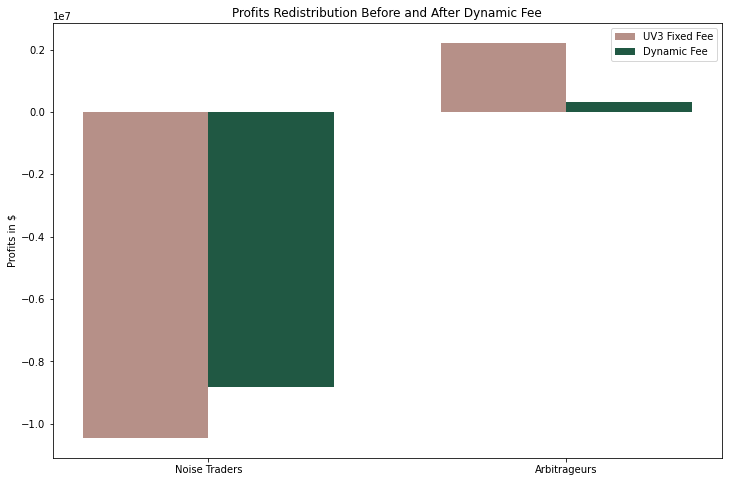

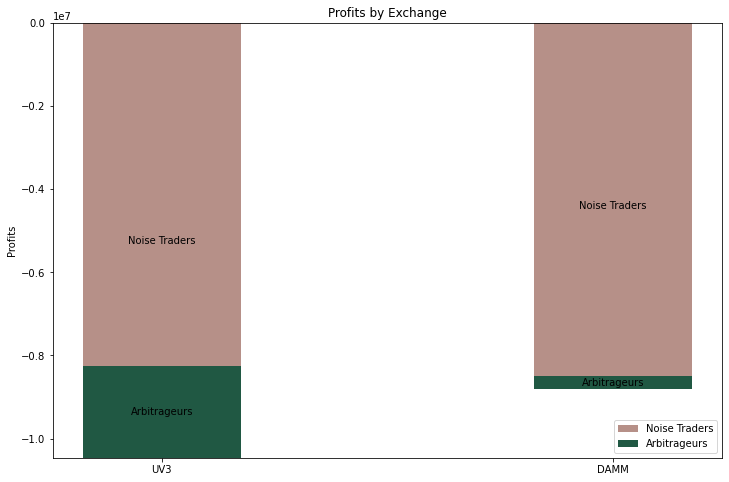

In [25]:
df['notional_profit'] = df.apply(lambda row: row['arb_profit_fixed']*row['amountUSD'], axis=1)

# keep the index of sell orders, and convert delta_p to positive
index_sell_df = df[df['delta_p']<0].index
df['delta_p'] = df['delta_p'].abs()

X = df['delta_p'].values.reshape(-1,1)
y_df = model_ols.predict(X)

df.loc[index_sell_df, 'delta_p'] = -df.loc[index_sell_df, 'delta_p']


df['f_dynamic'] = np.array(y_df)
df['f_dynamic'] = df.apply(lambda row: calc_f_dynamic(row, f_min, f_max, intercept_constant), axis=1)
df['damm_fee'] = df.apply(lambda row: calc_damm_fee(row), axis=1)
df['arb_profit_dynamic'] = df['notional_profit'] - df['damm_fee']
cex_noise_profit, cex_arb_profit = analyze_profit_redistribution(df)


In [26]:
df['damm_fee'].sum()/df['pool_fee'].sum()

1.0738882774024285

In [27]:
cex_noise_profit.sum(), cex_arb_profit.sum()

(-10464079.510141138, 2219906.3327628113)

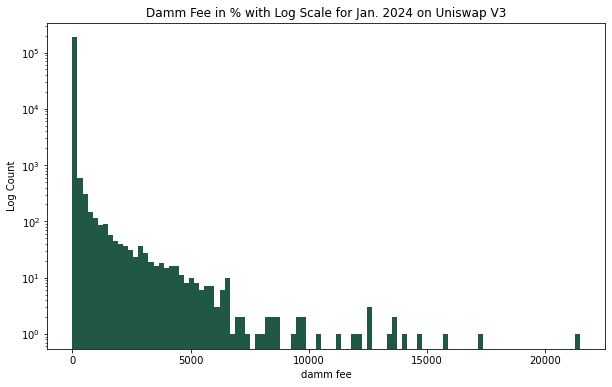

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(df['damm_fee'], bins=100, log=True, color="#205843")

locs, labels = plt.xticks()


plt.xlabel('damm fee')
plt.ylabel('Log Count')
plt.title('Damm Fee in % with Log Scale for Jan. 2024 on Uniswap V3')
plt.show()

In [29]:
print(f"{len(df[df['f_dynamic']<0.0005])/len(df)*100:.4f}% of the trades are charged less 5 bps")

95.7912% of the trades are charged less 5 bps


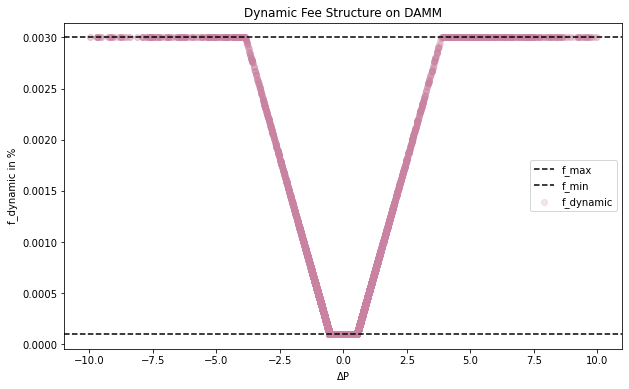

In [30]:
df_normal = df[(df['delta_p']>=-10)&(df['delta_p']<=10)]
plt.figure(figsize=(10, 6))
plt.scatter(df_normal['delta_p'], df_normal['f_dynamic'], color='#C982A1', alpha=0.2, label="f_dynamic")
plt.axhline(f_max, label='f_max', color='black', linestyle='--')
plt.axhline(f_min, label='f_min', color='black', linestyle='--')

# plt.scatter(df_normal['delta_p'], df_normal['arb_profit_fixed'], color='purple', alpha=0.2)
plt.xlabel("$\Delta$P")
plt.ylabel("f_dynamic in %")
plt.legend()
plt.title("Dynamic Fee Structure on DAMM")
plt.show()

<Figure size 720x432 with 0 Axes>

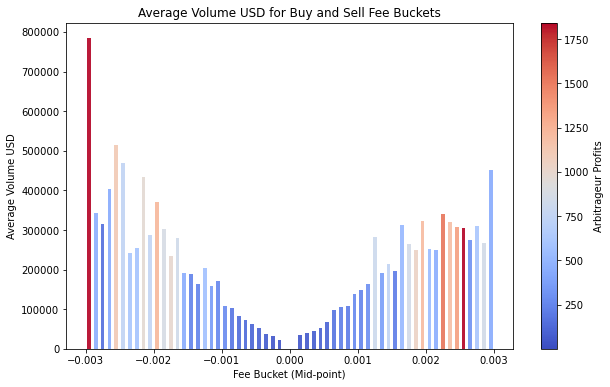

In [35]:
from matplotlib.cm import ScalarMappable


df1=df.copy()

# separate buy and sell
df1['f_dynamic']=df1.apply(lambda row: -row['f_dynamic'] if row['amount1']>0 else row['f_dynamic'], axis=1)
# Adjusting bins to a higher value for finer granularity
df1['fee_bucket'] = pd.cut(df1['f_dynamic'], bins=60)  # Adjusted number of bins from 10 to 20

bucket_ratio = df1.groupby('fee_bucket')['is_arb'].mean().reset_index()
# Convert intervals to mid-points for plotting
bucket_ratio['fee_bucket_mid'] = bucket_ratio['fee_bucket'].apply(lambda x: x.mid).astype(float)

# Calculate the average 'volumeUSD' for each bucket
agg_metrics = df1.groupby('fee_bucket')[['amountUSD','arb_profit_dynamic']].mean().reset_index()
agg_metrics['arb_profit_dynamic'].fillna(0, inplace=True)

# Convert intervals to mid-points for plotting
agg_metrics['fee_bucket_mid'] = agg_metrics['fee_bucket'].apply(lambda x: x.mid).astype(float)


# Set the amountUSD in (0.0, 0.0001] to 0
agg_metrics.loc[agg_metrics['fee_bucket'] == pd.Interval(0.0, 0.0001, closed='right'), 'amountUSD'] = 0
agg_metrics.loc[agg_metrics['fee_bucket'] == pd.Interval(-0.0001, 0.0, closed='right'), 'arb_profit_dynamic'] = 1
agg_metrics.loc[agg_metrics['fee_bucket'] == pd.Interval(-0.0001, 0.0, closed='right'), 'amountUSD'] = 0

# agg_metrics['arb_profit_dynamic'] = np.log(agg_metrics['arb_profit_dynamic'].abs())
agg_metrics['arb_profit_dynamic'] = agg_metrics['arb_profit_dynamic'].abs()
# bins = np.linspace(agg_metrics['arb_profit_dynamic'].min(), agg_metrics['arb_profit_dynamic'].max(), num=60)  # Create 10 bins
# agg_metrics['arb_profit_dynamic'] = pd.Series(np.digitize(agg_metrics['arb_profit_dynamic'], bins))

# Map the ratio to a color
# agg_metrics['arb_profit_dynamic'] = np.log(agg_metrics['arb_profit_dynamic']).abs()

arb_pnl_norm = Normalize(vmin=agg_metrics['arb_profit_dynamic'].min(), vmax=agg_metrics['arb_profit_dynamic'].max())
norm_arb_pnl = arb_pnl_norm(agg_metrics['arb_profit_dynamic'])

colors = coolwarm(norm_arb_pnl)

sm = ScalarMappable(cmap=coolwarm, norm=arb_pnl_norm)
sm.set_array([])
plt.figure(figsize=(10, 6))


plt.figure(figsize=(10, 6))
for idx, row in agg_metrics.iterrows():
    plt.bar(row['fee_bucket_mid'], row['amountUSD'], alpha=0.7, color=colors[idx], width=np.min(np.diff(agg_metrics['fee_bucket_mid']))/1.8)
plt.bar(agg_metrics['fee_bucket_mid'], agg_metrics['amountUSD'], alpha=0.7, color=colors, width=np.min(np.diff(agg_metrics['fee_bucket_mid']))/1.8)

plt.colorbar(sm, label='Arbitrageur Profits')

plt.title('Average Volume USD for Buy and Sell Fee Buckets')
plt.xlabel('Fee Bucket (Mid-point)')
plt.ylabel('Average Volume USD')

plt.show()

In [ ]:
df['damm_fee'].mean()/df['amountUSD'].mean()

0.0005369441387012141